## Laboratorium 8.2


## Przepływ optyczny i śledzenie obiektów

### Wprowadzenie

Metodę przepływu optycznego (między innymi) można stosować również do śledzenia obiektów. Zazwyczaj wykorzystuje się w tym celu metody rzadkie połączone ze znanymi już nam metodami detekcji punktów zainteresowania. Procedura przebiega podobnie jak w przypadku gęstego przepływu (tzn. operujemy na parze klatek w skali szarości, znajdujemy wektory przesunięć), z tą różnicą że obliczanie przepływu zachodzi wyłącznie dla interesujących nas punktów - a zatem musimy znać ich położenia, aby zainicjować proces. Można sobie wyobrazić różne sposoby zlokalizowania punktów kluczowych, w zależności od konkretnego zastosowania i założeń: być może np. pipeline do przetwarzania rozpoczyna się od detekcji obiektów, a może z góry wiemy, gdzie obiekty się początkowo znajdują.

W OpenCV podstawową metodą do obliczania przepływu dla zbioru punktów jest metoda Lucasa-Kanade, zaimplementowana w funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323). Podobnie jak w metodzie Farnebacka, argument `nextPts` ustawiamy na `None` (chyba, że chcemy zainicjować rozwiązanie już znanymi położeniami punktów, ale w praktyce z reguły nie będziemy mieli takiej wygody), argumenty `status` i `err` pomijamy zupełnie. W odróżnieniu od Farnebacka, wynikiem są absolutne położenia punktów na drugiej klatce (a nie wektory przesunięć). Dodatkowo otrzymujemy też wektor `status` informujący dla każdego punktu, czy udało się go odnaleźć, oraz `err` mierzący jakąś miarę błędu wizualnego pomiędzy fragmentem obrazu zawierającym dany punkt kluczowy.

Do inicjalizacji rozwiązania można wykorzystać znane nam metody znajdowania punktów kluczowych, albo opartą o detektor Harrisa funkcję [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541) - jest nieco prostsza w użyciu, bo na wyjściu otrzymujemy po prostu macierz `np.float32` o wymiarach $Nx1x2$ zawierającą koordynaty znalezionych punktów.

Oczywiście, śledzenie obiektów oparte o jednorazową inicjalizację jest narażone na błędy: zniknięcie lub tymczasowe zasłonięcie śledzonego obiektu, czy choćby zmiana jego wyglądu (np. wskutek pojawienia się cienia) mogą spowodować, że przepływ nie zostanie obliczony. Może być też pożądana możliwość śledzenia ciągłego z uwzględnieniem pojawiania się nowych obiektów (np. monitorowanie CCTV). W takich sytuacjach konieczne jest regularne odświeżanie inicjalizacji, tj. ponowne wykrycie interesujących obiektów. To z kolei prowadzi do kolejnego problemu: jeżeli interesuje nas cała historia ruchu danych obiektów, przy czym do pewnego momentu ich lokalizacje uzyskiwaliśmy za pomocą przepływu optycznego, a w pewnym momencie wykonaliśmy ponowną detekcję - to jak powiązać jedno z drugim, by zapewnić ciągłość lokalizacji? To zagadnienie, oraz pozostałe tematy dyskutowane w tym kontekście na wykładzie, nie będzie jednak centralne na laboratorium.

---

### Cel zadania

Celem tej listy jest (1) zapoznanie się z metodą przepływu optycznego rzadkiego do zastosowań śledzenia obiektów, oraz (2) zastosowanie tej techniki w praktyce, na przykładzie monitorowania prędkości obiektu (w metrach na sekundę). Przykładem badawczym będzie nagranie startu Wahadłowca Kosmicznego _Discovery_ (misja [STS-124](https://en.wikipedia.org/wiki/STS-124)), zarejestrowane jedną z kamer technicznych (plik `shuttle.mp4`).

Aby obliczyć prędkość, potrzebna jest znajomość drogi (w metrach) i czasu (w sekundach). Czas między klatkami obliczysz, znając liczbę klatek na sekundę, którą możesz pobrać bezpośrednio z otwartego obiektu `VideoCapture` za pomocą następującej konstrukcji:  
```python
fps = source.get(cv2.CAP_PROP_FPS)
```  
Wyznaczenie przelicznika między przestrzenią obrazu (w pikselach) a przestrzenią świata (w metrach) jest w ogólności [nieco złożonym zagadnieniem](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html); znalezienie uproszczonej alternatywy jest Twoim zadaniem.

Źródło nagrania: [_"Best of the Best" Provides New Views, Commentary of Shuttle Launches_ (NASA @ YouTube)](https://www.youtube.com/watch?v=vFwqZ4qAUkE), 29:06.5  
Nagranie o oryginalnej prędkości ~225 fps odtwarzane przy typowej prędkości 30fps wyglądałoby na spowolnione w proporcji ok. 1:7.5; zostało zatem przekodowane tak, aby osiągnąć zbieżność upływu czasu 1:1 z rzeczywistym. Możesz się o tym upewnić patrząc na _timestamp_ z prawej strony nagrania ([_jak go czytać_](https://space.stackexchange.com/a/38569)).

In [2]:
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

### Zadanie 1

Na podstawie pierwszej klatki z materiału dokonaj kalibracji parametrów detektora cech do śledzenia (sugerowany detektor: [`cv2.goodFeaturesToTrack`](https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga1d6bb77486c8f92d79c8793ad995d541)). Dobór tych parametrów jest kluczowy dla reszty zadania, więc zapoznaj się z ich znaczeniem i postaraj tak dobrać, by uzyskać odpowiednio dużo (10+) punktów w rejonie śledzonego obiektu.

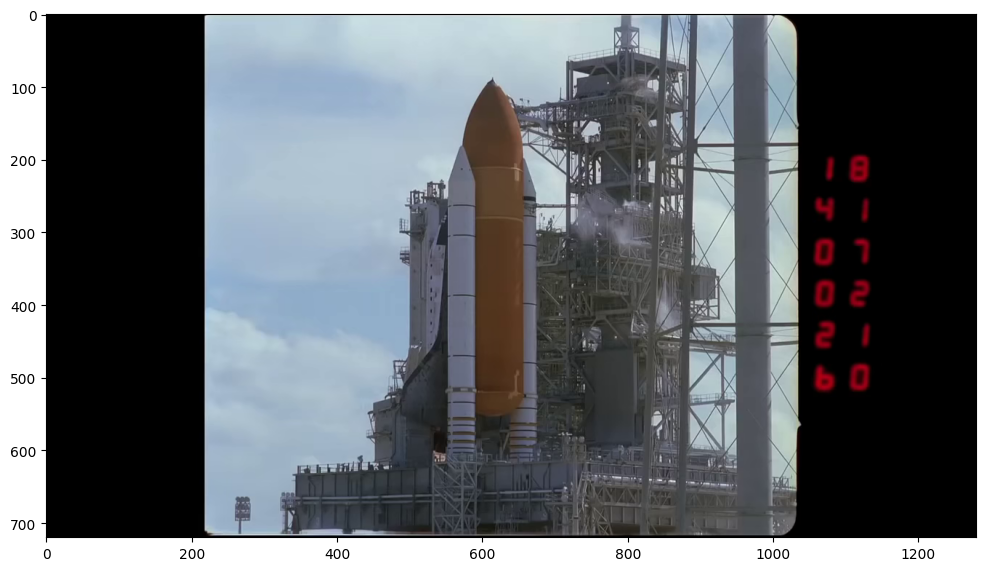

In [3]:
source = cv2.VideoCapture('shuttle.mp4')
status, frame = source.read()
source.release()
plt.subplots(1, 1, figsize=(12,12))[1].imshow(frame[..., ::-1]);

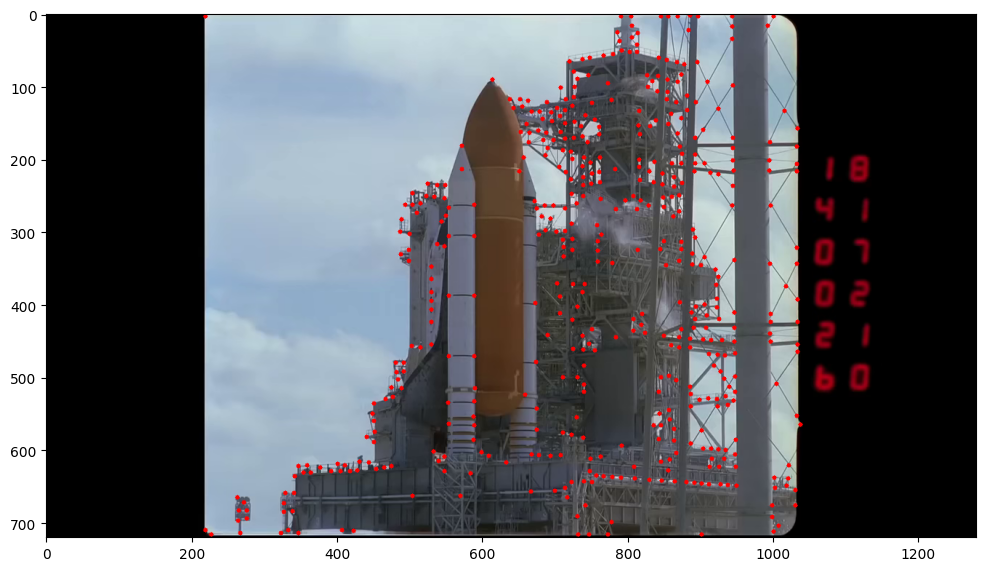

In [4]:
img = frame[..., ::-1].copy() 
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
corners = cv2.goodFeaturesToTrack(gray_img, maxCorners = 500, qualityLevel = 0.05, minDistance = 10)
corners = np.intp(corners)

for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, (255, 0, 0), -1)
plt.subplots(1, 1, figsize=(12, 12))[1].imshow(img)

if cv2.waitKey(0) & 0xff == 27:  
    cv2.destroyAllWindows() 

### Zadanie 2

Uzupełnij daną poniżej podstawową pętlę analizy wideo o śledzenie obiektów: inicjalizację i wykorzystanie przepływu optycznego do aktualizacji ich położenia. Celem jest pozyskanie pełnej trajektorii pojazdu, tak aby można było ją narysować (np. [`cv2.polylines`](https://docs.opencv.org/3.4/d6/d6e/group__imgproc__draw.html#gaa3c25f9fb764b6bef791bf034f6e26f5)) tudzież przetwarzać dalej.

Zapoznaj się dobrze z dokumentacją funkcji [`cv2.calcOpticalFlowPyrLK`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323), zwłaszcza z wartościami zwracanymi, **zwłaszcza** `status`. Upewnij się, że odpowiednio obsługujesz przypadki niepowodzenia znalezienia przepływu dla poszczególnych punktów.

Wynik zaprezentuj w postaci graficznej (narysowane trajektorie).

In [10]:
from IPython.display import display, clear_output
from PIL import Image

In [11]:
def baseLoop(source: cv2.VideoCapture):
    frame1 = None
    status, frame2 = source.read()
    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # corner detection params
    features_params = dict(maxCorners = 500,
                           qualityLevel = 0.05,
                           minDistance = 40,
                           blockSize = 7)
    # Lucas-Kanade params
    lk_params = dict(winSize = (15, 15),
                     maxLevel = 2,
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # corner detection mask
    h, w = frame2_gray.shape
    mask = np.zeros_like(frame2_gray)
    bottom = int(0.8 * h)
    top = int(0 * h)
    left = int(0.45 * w)
    right = int(0.51 * w)
    mask[top:bottom, left:right] = 255
    
    # corner detection
    p0 = cv2.goodFeaturesToTrack(frame2_gray, 
                                 mask = mask,
                                 **features_params)
    # matrix for drawing purposes
    drawing_fig = np.zeros_like(frame2)
    
    while status:
        frame1 = frame2_gray
        status, frame2 = source.read()
        if not status:
            break
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
        
        p1, st, err = cv2.calcOpticalFlowPyrLK(frame1, 
                                               frame2_gray, 
                                               p0, 
                                               None, 
                                               **lk_params)
        # select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        
        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            drawing_fig = cv2.line(drawing_fig, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (int(a), int(b)), 5, (0, 0, 255), -1)
        img = cv2.add(frame2, drawing_fig)
        
        # Convert the image to RGB (OpenCV uses BGR by default)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Convert the image to a PIL Image
        img_pil = Image.fromarray(img_rgb)
        # Display the image in the notebook
        clear_output(wait=True)
        display(img_pil)
        if cv2.waitKey(30) & 0xFF == 27:
            break
        # update points
        p0 = good_new.reshape(-1, 1, 2)
        
    cv2.destroyAllWindows()
    source.release()   

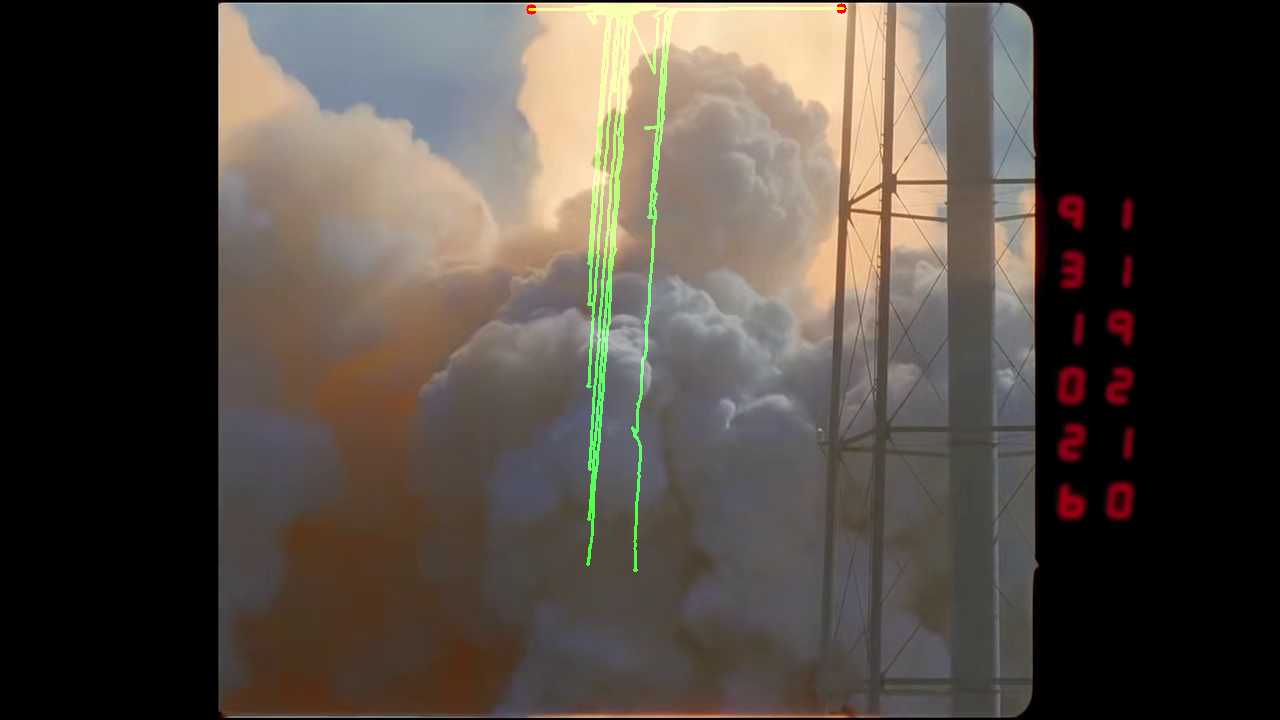

In [12]:
baseLoop(cv2.VideoCapture('shuttle.mp4'))

In [14]:
import cv2
import numpy as np
from IPython.display import display, clear_output, Video
import ipywidgets as widgets

# Global variable to control the loop
running = False

def baseLoop(source: cv2.VideoCapture, output_path: str):
    global running
    frame1 = None
    status, frame2 = source.read()
    if not status:
        print("Failed to read video")
        return

    frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    # corner detection params
    features_params = dict(maxCorners=500,
                           qualityLevel=0.05,
                           minDistance=40,
                           blockSize=7)
    # Lucas-Kanade params
    lk_params = dict(winSize=(15, 15),
                     maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
    # corner detection mask
    h, w = frame2_gray.shape
    mask = np.zeros_like(frame2_gray)
    bottom = int(0.8 * h)
    top = int(0 * h)
    left = int(0.45 * w)
    right = int(0.51 * w)
    mask[top:bottom, left:right] = 255

    # corner detection
    p0 = cv2.goodFeaturesToTrack(frame2_gray,
                                 mask=mask,
                                 **features_params)
    # matrix for drawing purposes
    drawing_fig = np.zeros_like(frame2)

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (frame2.shape[1], frame2.shape[0]))

    while status and running:
        frame1 = frame2_gray
        status, frame2 = source.read()
        if not status:
            break
        frame2_gray = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        p1, st, err = cv2.calcOpticalFlowPyrLK(frame1,
                                               frame2_gray,
                                               p0,
                                               None,
                                               **lk_params)
        # select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            drawing_fig = cv2.line(drawing_fig, (int(a), int(b)), (int(c), int(d)), (0, 255, 0), 2)
            frame2 = cv2.circle(frame2, (int(a), int(b)), 5, (0, 0, 255), -1)
        img = cv2.add(frame2, drawing_fig)

        # Write the frame to the output video file
        out.write(img)

        if cv2.waitKey(30) & 0xFF == 27:
            break
        # update points
        p0 = good_new.reshape(-1, 1, 2)

    out.release()
    cv2.destroyAllWindows()
    source.release()

def start_video():
    global running
    running = True
    source = cv2.VideoCapture('shuttle.mp4')
    output_path = 'output.mp4'
    baseLoop(source, output_path)
    display(Video(output_path, embed=True))

def stop_video():
    global running
    running = False

def restart_video():
    stop_video()
    start_video()

# Create buttons
start_button = widgets.Button(description="Start")
stop_button = widgets.Button(description="Stop")
restart_button = widgets.Button(description="Restart")

# Assign button actions
start_button.on_click(lambda x: start_video())
stop_button.on_click(lambda x: stop_video())
restart_button.on_click(lambda x: restart_video())

# Display buttons
display(start_button, stop_button, restart_button)

Button(description='Start', style=ButtonStyle())

Button(description='Stop', style=ButtonStyle())

Button(description='Restart', style=ButtonStyle())

### Zadanie 3

Dokonaj analizy znalezionych trajektorii i znajdź prędkość _Discovery_.

Wersja minimum: załóż, że pojazd porusza się z lokalnie stałą prędkością.  
Wersja normalna: wykreśl prędkość pojazdu jako funkcję czasu.  
Wersja z plusem: zastosuj odpowiednią filtrację funkcji położenia, by uniezależnić funkcję czasu od szumu.